In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib
#import anvil.server
import math
import warnings
#anvil.server.connect("MULC3WA3OE5ETI6GT6HMSZRI-ZKH2WPDHB453YQOY")
warnings.filterwarnings("ignore") # ignore warning
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns',1000)
pd.set_option("display.max_colwidth", None)

In [2]:
! pip install anvil-uplink
! pip install anvil
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           7288        219  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27           1395         35  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31        

In [3]:
!kaggle datasets list -s"YouTube Trending Video Dataset (updated daily)"
!kaggle datasets download -d "rsrishav/youtube-trending-video-dataset" -p "/content/new_data"

ref                                                          title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rsrishav/youtube-trending-video-dataset                      YouTube Trending Video Dataset (updated daily)    1GB  2022-12-10 12:33:35          16017        392  1.0              
datasnaek/youtube                                            Trending YouTube Video Statistics and Comments   56MB  2017-10-25 19:26:15          19699        324  0.7647059        
syahrulhamdani/indonesias-trending-youtube-video-statistics  Indonesia's Trending YouTube Video Statistics    74MB  2022-12-10 06:00:58           1535         60  1.0              
jessevent/all-kaggle-datasets                                Complete Kaggle Datasets Collectio

In [4]:
filepath1 = ""
filepath2 = ""
from zipfile import ZipFile
with ZipFile(r"/content/new_data/youtube-trending-video-dataset.zip") as myzip:
    filepath1 = myzip.open("US_category_id.json")
    filepath2 = myzip.open("US_youtube_trending_data.csv")

category_id_df = pd.read_json(filepath1)
videos_df = pd.read_csv(filepath2,header='infer')
#videos_df.head()
def clean_video_csv(video_df,country_code):
    """
    This function is to remove unnecessary chars like '"',',','\r'which will cause errors when copy csv files into staging table.
    
    Parameters:
    video_df: Dataframe from read_csv file
    filepath: videos csv filepath
    
    Return:
    video_df: Dataframe which remove unnecessary chars
    """
    video_df["tags"] = video_df["tags"].apply(lambda x:x.replace('"',""))
    video_df["title"] = video_df["title"].apply(lambda x:x.replace(',',' '))
    video_df["channelTitle"] = video_df["channelTitle"].apply(lambda x:x.replace(',',' '))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace('\r',''))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace(',',' '))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace('"',''))
    video_df["country"] = country_code
    return video_df
#Clean videos csv files for selected country code
country_code='US'
"""
for c in country_code:
    filepath= "new_data/"+c+"_youtube_trending_data.csv"
    video_df = pd.read_csv(filepath,header='infer')
    savepath = "new_data/"+c+"cleaned_data.csv"
    video_df = clean_video_csv(video_df,c)
    video_df.to_csv(savepath,index=False)
"""
#filepath= "new_data/"+c+"_youtube_trending_data.csv"
#$video_df = pd.read_csv(filepath,header='infer')
savepath = "new_data/"+country_code+"cleaned_data.csv"
video_df = clean_video_csv(videos_df,country_code)
video_df.to_csv(savepath,index=False)

def category_extract (df,country_code):
    """
    The function is to extract category id and category title from category_id json files
    
    Parameters:
    df: Dataframe of read_json file
    filepath: category_id json filepath
    
    Return:
    category_df: Dataframe with columns: category_id,category_title,category_filename,country_code
    
    """
    category_id = []
    category_title = []
    for i in range(df.shape[0]):
        category_id.append(df.iloc[i]["items"]['id'])
        category_title.append(df.iloc[i]["items"]["snippet"]["title"])
    category_df = pd.DataFrame()
    category_df["category_id"] = category_id
    category_df["category_title"] = category_title
    category_df.insert(category_df.shape[1],"country_code",country_code)
    return category_df

#Extract category title and id from json file of each country

"""
category_all = pd.DataFrame()
for c in country_code:
    filepath="new_data/"+c+"_category_id.json"
    category_id_df = pd.read_json(filepath)
    category_all = pd.concat([category_all,category_extract(category_id_df,c)])
    
#category_all.tail()
savepath = "new_data/category_all.csv"
category_all.to_csv(savepath,index=False)
"""
category_all = pd.DataFrame()
category_all = pd.concat([category_all,category_extract(category_id_df,country_code)])
savepath = "new_data/category_all.csv"
category_all.to_csv(savepath,index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170990 entries, 0 to 170989
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           170990 non-null  object
 1   title              170990 non-null  object
 2   publishedAt        170990 non-null  object
 3   channelId          170990 non-null  object
 4   channelTitle       170990 non-null  object
 5   categoryId         170990 non-null  int64 
 6   trending_date      170990 non-null  object
 7   tags               170990 non-null  object
 8   view_count         170990 non-null  int64 
 9   likes              170990 non-null  int64 
 10  dislikes           170990 non-null  int64 
 11  comment_count      170990 non-null  int64 
 12  thumbnail_link     170990 non-null  object
 13  comments_disabled  170990 non-null  bool  
 14  ratings_disabled   170990 non-null  bool  
 15  description        167075 non-null  object
 16  country            1

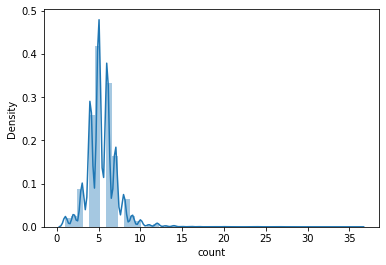

In [5]:
US = pd.read_csv("new_data/UScleaned_data.csv")
category = pd.read_csv("new_data/category_all.csv")
trendingdate_df = US.groupby("video_id").trending_date.describe().reset_index()
pd.DataFrame(trendingdate_df["count"].astype('int').copy()).describe()
sns.distplot(trendingdate_df["count"])
US1 =US.merge(category,how="inner",left_on=["categoryId","country"],right_on=["category_id","country_code"])
US1.info()

In [6]:
US1["trending_date1"] = US1["trending_date"].apply(lambda x: pd.Timestamp(int(x[0:4]),int(x[5:7]),int(x[8:10]),0))
columns = ["video_id","trending_date1","channelTitle","publishedAt","view_count","likes","dislikes","comment_count","category_title"]
US1 = US1[columns].copy()
videos = trendingdate_df[trendingdate_df["count"].values>=6].video_id
US2 = US1[ US1.video_id.isin(videos.values)]

In [7]:
videos_df[videos_df["view_count"].idxmax():videos_df["view_count"].idxmax()+1]

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,country
152788,gQlMMD8auMs,BLACKPINK - ‘Pink Venom’ M/V,2022-08-19T04:00:13Z,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2022-09-10T00:00:00Z,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블핑|제니|로제|리사|지수|LISA|JISOO|JENNIE|ROSÉ|BLINK|블링크|BLACKPINK PINK VENOM|PINK VENOM|핑크베놈|블랙핑크 핑크베놈|BLACKPINK 핑크베놈|BORN PINK|BLACKPINK BORN PINK|본핑크|블랙핑크 본핑크,277791741,12993894,0,3534337,https://i.ytimg.com/vi/gQlMMD8auMs/default.jpg,False,False,BLACKPINK - ‘Pink Venom’ M/VKick in the door Waving the coco 팝콘이나 챙겨 껴들 생각 말고I talk that talk Runways I walk walk 눈 감고 pop pop 안 봐도 척 One by one then Two by two내 손끝 툭 하나에 다 무너지는 중가짜 쇼 치곤 화려했지Makes no sense You couldn’t get a dollar outta me자 오늘 밤이야 난 독을 품은 꽃네 혼을 빼앗은 다음 Look what you made us do 천천히 널 잠재울 FIRE 잔인할 만큼 아름다워 I bring the pain like This that pink venomThis that pink venomThis that pink venomGet ‘em get ‘em get ‘emStraight to ya dome like whoa whoa whoa Straight to ya dome like ah ah ah Taste that pink venomTaste that pink venomTaste that pink venomGet ‘em get ‘em get ‘emStraight to ya dome like whoa whoa whoa Straight to ya dome like ah ah ah Black paint and ammo got bodies like RamboRest in peace please light up a candleThis da life of a vandal masked up and I’m still in CelineDesigner crimes or it wouldn’t be meDiamonds shinin’ drive in silence I don’t mind it I’m ridin’ Flyin’ private side by side with da pilot Up in the sky And I’m wildin’ stylin’ on them and there’s no chanceCuz we got bodies on bodies like this a slow dance 자 오늘 밤이야 난 독을 품은 꽃네 혼을 빼앗은 다음 Look what you made us do 천천히 널 잠재울 FIRE 잔인할 만큼 아름다워 I bring the pain likeThis that pink venomThis that pink venomThis that pink venomGet ‘em get ‘em get ‘emStraight to ya dome like whoa whoa whoa Straight to ya dome like ah ah ah Taste that pink venomTaste that pink venomTaste that pink venomGet ‘em get ‘em get ‘emStraight to ya dome like whoa whoa whoa Straight to ya dome like ah ah ah 원한다면 provoke us감당 못해 and you know this이미 퍼져버린 shot that potion 네 눈앞은 핑크빛 oceanCome and give me all the smoke 도 아니면 모 like I’m so rock and roll Come and give me all the smoke 다 줄 세워 봐 자 STOP DROPI bring the pain likeLa tatata La tatata La tatata La tatata La tatata La tatata Straight to yaStraight to yaStraight to ya dome likeLa tatata La tatata La tatata La tatataLa tatata La tatataI bring the pain like 00:00 Pink Venom01:56 Join the #PinkVenomChallenge 02:11 Only on YouTube Shorts More about BLACKPINK @http://www.blackpinkofficial.com/http://www.facebook.com/BLACKPINKOFFICIALhttp://www.youtube.com/BLACKPINKOFFICIALhttps://www.instagram.com/BLACKPINKOFFICIALhttps://twitter.com/BLACKPINK#BLACKPINK #블랙핑크 #PreReleaseSingle #PinkVenom #MV #20220819_12amEST #20220819_1pmKST #OutNow #YG,US


In [8]:
def standardize(data):
    scaler = StandardScaler()
    scaler = scaler.fit(data)
    transformed = scaler.transform(data)
    return scaler,transformed
scaler_views, US_views = standardize(US2.view_count.values.reshape(-1,1))

In [9]:
mean_view = scaler_views.mean_
mean_view = mean_view[0]
var_view = scaler_views.var_
sqr_view = math.sqrt(var_view)

In [10]:
US3 = pd.DataFrame()
US3["trending_date1"] = US2["trending_date1"]
US3["video_id"] = US2["video_id"]
US3["views"] = US_views
US3.reset_index(inplace=True)
US3.drop("index",axis=1,inplace=True)

In [11]:
x=[]
y=[]
#category = []
for v in videos:
    row=[]
    temp_df = US3[US3["video_id"]==v].sort_values(by="trending_date1")
    #print (temp_df)
    seq = temp_df.views[0:5].index #first 5 views as input
    #print(seq)    
    for s in seq:
        #print (US3.iloc[s].values[2:])
        row.append(US3.iloc[s].values[2:])
    #print(row)
    x.append(row)
    nextstep = temp_df.views[5:6].values # the last views as output
    y.append(nextstep)

In [12]:
x = np.reshape(x,(len(x),5,1)) # new
print (x.shape)
y = np.reshape(y,(-1,1))
print (y.shape)
x = x.astype('float64')
y = y.astype('float64')

(13638, 5, 1)
(13638, 1)


In [13]:
from sklearn.model_selection import ShuffleSplit,train_test_split
x_train,x_testall,y_train,y_testall = train_test_split(x,y,test_size=0.4,random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_testall,y_testall,test_size=0.5,random_state=42)

In [14]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.layers.core import Dense, Activation, Dropout
import keras
model = Sequential()
model.add(LSTM(64, return_sequences=True,input_shape=(5, 1),activation='tanh'))#32 is output,  input shape是3维: (Batch_size, Time_step, Input_Sizes),
model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=True,activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=False,activation='tanh'))
model.add(Dense(1, activation='linear'))#1 is output
#optimizer = RMSprop(lr=0.005)
optimizer = RMSprop(learning_rate=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='model_3.hdf5', 
                               verbose=1, save_best_only=True)

train_model = model.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          epochs=50, batch_size=64, callbacks=[checkpointer], verbose=1)
model.load_weights('model_3.hdf5')

Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 0.2691
Epoch 1: val_loss improved from inf to 0.07142, saving model to model_3.hdf5
128/128 [==============================] - 15s 57ms/step - loss: 0.2691 - val_loss: 0.0714
Epoch 2/50
127/128 [============================>.] - ETA: 0s - loss: 0.1088
Epoch 2: val_loss improved from 0.07142 to 0.01490, saving model to model_3.hdf5
128/128 [==============================] - 6s 44ms/step - loss: 0.1082 - val_loss: 0.0149
Epoch 3/50
128/128 [==============================] - ETA: 0s - loss: 0.0703
Epoch 3: val_loss did not improve from 0.01490
128/128 [==============================] - 6s 44ms/step - loss: 0.0703 - val_loss: 0.0614
Epoch 4/50
128/128 [==============================] - ETA: 0s - loss: 0.0686
Epoch 4: val_loss improved from 0.01490 to 0.01487, saving model to model_3.hdf5
128/128 [==============================] - 6s 45ms/step - loss: 0.0686 - val_loss: 0.0149
Epoch 5/50
127/128 [=========================

In [15]:
train_model.history.keys()

dict_keys(['loss', 'val_loss'])

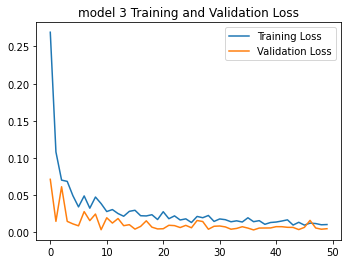

In [16]:
import matplotlib.pyplot as plt
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('model 3 Training and Validation Loss')
plt.show()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            98816     
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 247,425
Trainable params: 247,425
Non-trai

In [18]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
predict_train = model.predict(x_train)
predict_test = model.predict(x_test)
# invert predictions
predict_train = scaler_views.inverse_transform(predict_train)
y_train = scaler_views.inverse_transform(y_train)
predict_test = scaler_views.inverse_transform(predict_test)
y_test= scaler_views.inverse_transform(y_test)
nsamples, nx, ny = x_test.shape
d2_x_test = x_test.reshape((nsamples,nx*ny))
x_test_rev = scaler_views.inverse_transform(d2_x_test)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(predict_test, y_test))
print('Val Score: %.2f RMSE' % (valScore))
predict = scaler_views.inverse_transform(model.predict(x_test))
print ("the demo predict is %s" %(predict.astype('int')[10:20]))
print ("the demo train is %s" %(x_test_rev[10:20]))
print ("the demo true is %s" %(y_test.astype('int')[10:20]))
#print(y_test[0:50])

86/86 [==============================] - 1s 11ms/step
Train Score: 1141498.16 RMSE
Val Score: 515023.94 RMSE
86/86 [==============================] - 1s 11ms/step
the demo predict is [[  896215]
 [ 1603678]
 [  408186]
 [  765321]
 [  476005]
 [ 2189973]
 [ 5805963]
 [ 5447744]
 [ 1888444]
 [13377924]]
the demo train is [[  519623.   766167.   835582.   902875.   937627.]
 [ 1382225.  1404916.  1564969.  1621845.  1681713.]
 [  172040.   208791.   222006.   228688.   234884.]
 [  402647.   560134.   645619.   732011.   784235.]
 [  206703.   292697.   323838.   343023.   345813.]
 [ 1336020.  1721129.  1959172.  2119100.  2270690.]
 [ 4755586.  5196441.  5443108.  5618107.  5702575.]
 [ 4230805.  4593334.  4928864.  5165405.  5346463.]
 [  939081.  1500943.  1771438.  1897154.  1963604.]
 [ 6370515.  7815386.  9638948. 10729015. 12139092.]]
the demo true is [[  951120]
 [ 1726825]
 [  237630]
 [  825176]
 [  347088]
 [ 2370577]
 [ 5753953]
 [ 5484760]
 [ 2009606]
 [13034795]]
